In [1]:
# JSS
## TODO 
#using pca to reduce the dimensionality of the global descriptors
#using MobileVnet instead of netVLAD
#using hfnet instead of netVlAD and MobileVnet --that is not working 
# this will also help reduce the complexity 
#understand what superglue is outputting
# getting two models from SFM 
# Setting up the scale of the model -- this is done easy and simple
import numpy as np
import argparse
import yaml
import logging
from pathlib import Path
from tqdm import tqdm
from pprint import pformat
import h5py
import json
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from shutil import copyfile
import os
import sys
import collections
import struct
import argparse
import logging
import torch
import json
from hfnet.settings import EXPER_PATH
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
tf.contrib.resampler  # import C++ op
%load_ext autoreload
%autoreload 2
%matplotlib inline

# from notebooks.utils import plot_images, plot_matches, add_frame

from hfnet.models import get_model  
import Image_functions
import  jsonparser
from hloc.utils import viz
from hloc import  visualization

W0302 10:58:13.867781 139706515814208 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [3]:
### This is for robot lab trajectory 3 
"""
wget https://doc-0o-34-docs.googleusercontent.com/docs/securesc/dn5p05vfr786umosrqispvvcmjgtdss2/372kqi9edicbd5spm3jap91tqp96u537/1614659850000/09043507770403126626/09236460614078308514/12TPwjQ-8_cgm3XCYVnBmCPcV_pL7yh_P?e=download&authuser=1
"""
### Please download the dataset in datasets
### set the path to image where you have downloaded the imagews
### here i am using path to images for map as these will be used to create the map
path_to_images_for_map = Path("/home/Hierarchical-Localization/datasets/UsefulImagesT3")

In [4]:
# send the path to the image directory and get the path to all the images in it
def image_directory_parser(path, viewer=True, number= 4):    
    globs=['*.jpg', '*.png', '*.jpeg', '*.JPG', '*.PNG']
    ## can also use sufix instead of with method
    image_path = []
    for g in globs:
        image_path += list(path.glob("**/"+g))
    print(len(image_path))
    if viewer:
        nrows = number
        ncols = number
        fig = plt.gcf()
        fig.set_size_inches(ncols*4, ncols*4)
        for i in range(2*number):
            sp = plt.subplot(nrows, ncols, i + 1)
            sp.axis('Off') # Don't show axes (or gridlines)
            img = mpimg.imread((image_path[i]))
            plt.imshow(img)
        plt.show()
    return image_path

1637


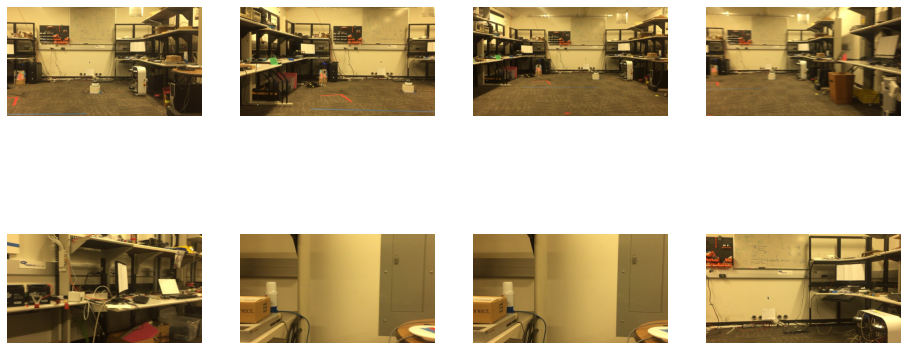

In [5]:
## image path will have path to all the images in it
## This will show 8 images 
image_path = image_directory_parser(path_to_images_for_map, viewer=True, number = 4)

In [6]:
# image dictionary creator gives image, its name and index as dictionary
def dictionary_of_images(image_path):
    image_dict ={}
    for i,j in tqdm(enumerate(image_path)):
        image_array = cv2.imread(str(j))
#         print(image_path[i].name)
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image_dict[i] = {"image":image_array, "name": image_path[i].name, "number": i}
    return image_dict

In [7]:
image_dict = dictionary_of_images(image_path)
print(len(image_dict))

1637it [00:19, 82.73it/s]

1637


In [8]:
## here set the path for output 
#"""sfm_T3_HFNET_pba""" 
output_path = Path("/home/Hierarchical-Localization/outputs/sfm_T3_HFNET_pba")
output_path.mkdir(exist_ok =True, parents= True)

In [9]:
class HFNet:
    def __init__(self, model_path, outputs):
        self.session = tf.Session()
        self.image_ph = tf.placeholder(tf.float32, shape=(None, None, 3))

        net_input = tf.image.rgb_to_grayscale(self.image_ph[None])
        tf.saved_model.loader.load(
            self.session, [tag_constants.SERVING], str(model_path),
            clear_devices=True,
            input_map={'image:0': net_input})

        graph = tf.get_default_graph()
        self.outputs = {n: graph.get_tensor_by_name(n+':0')[0] for n in outputs}
        self.nms_radius_op = graph.get_tensor_by_name('pred/simple_nms/radius:0')
        self.num_keypoints_op = graph.get_tensor_by_name('pred/top_k_keypoints/k:0')

    def inference(self, image, nms_radius=4, num_keypoints=1000):
        inputs = {
            self.image_ph: image[..., ::-1].astype(np.float),
            self.nms_radius_op: nms_radius,
            self.num_keypoints_op: num_keypoints,
        }
        return self.session.run(self.outputs, feed_dict=inputs)

In [10]:
model_path = Path("/home/Hierarchical-Localization/hfnet/model/saved_models/hfnet")

outputs = ['global_descriptor', 'keypoints', 'local_descriptors', 'scores']
hfnet = HFNet(model_path, outputs)

W0302 10:45:04.003038 140199748306752 deprecation.py:323] From <ipython-input-9-8a62a65d9558>:10: load (from tensorflow.python.saved_model.loader_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
W0302 10:45:04.851504 140199748306752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
I0302 10:45:04.853621 140199748306752 saver.py:1280] Restoring parameters from /home/Hierarchical-Localization/hfnet/model/saved_models/hfnet/variables/variables


In [11]:
global_feature_path = output_path/"global_features.h5"
local_feature_path = output_path/"local_feature.h5"
global_feature_file = h5py.File(str(global_feature_path), 'w')
local_feature_file = h5py.File(str(local_feature_path), 'w')
global_feature_dict = {}
for i in tqdm(range(len(image_dict))):
    image = (image_dict[i]["image"]).astype(float)
#     print(image.shape)
    name = image_dict[i]["name"]
    db = hfnet.inference(image)
    grp = global_feature_file.create_group(str(name))
    grp.create_dataset('global_descriptor', data=db['global_descriptor'])
    if i == 0:
        global_matrix = np.array(db['global_descriptor'])
    else:
        global_matrix = np.vstack((global_matrix,db['global_descriptor'])) 
    global_feature_dict[i] = {"global_descriptor":db['global_descriptor'], "name":name}
    grp = local_feature_file.create_group(str(name))
    size = np.array(image.shape[:2][::-1])
#     print(size)
    grp.create_dataset('keypoints', data=db['keypoints'])
    grp.create_dataset('descriptors', data=np.transpose(db['local_descriptors']))
    grp.create_dataset('scores', data=db['scores'])
    grp.create_dataset('image_size', data= size)
    
global_feature_file.close()
local_feature_file.close()

100%|██████████| 1637/1637 [00:45<00:00, 35.87it/s]


In [12]:
np.shape(global_matrix)

(1637, 4096)

In [15]:
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)
# Writing the .txt file. 
# this funtion creates the .txt for global matches
# similar matches are automatically removed by matcher featurea 
##hence dont worry about it :)
def text_file_for_global_matches(global_feature_dict, global_feature_matrix, path, number): 
    predictions_dict_matches = {}
    for i in tqdm(range(len(global_feature_dict))):
        current_descriptor = global_feature_matrix[i, :]
        neighbours = compute_distance(current_descriptor, global_feature_matrix)
        predictions_dict_matches[i] = ((np.argsort(neighbours))[:number])[1 :]
    #first writing the file
    output_file_txt = path/"global_feature.txt"
    with open(output_file_txt, 'w') as f:
        for i in tqdm(range(len(predictions_dict_matches))):
            current_image_name = global_feature_dict[i]["name"]
            current_image_matches = predictions_dict_matches[i]
            string_list = []
            for j in range(len(current_image_matches)):
                    if i == 0 and j ==0:
                        making_a_string = current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    
                    else: 
                        making_a_string = "\n" + current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    f.write(making_a_string) 

In [16]:
text_file_for_global_matches(global_feature_dict, global_matrix,output_path,50)

100%|██████████| 1637/1637 [00:00<00:00, 13505.74it/s]


In [9]:
### Bringing in HLOC
%load_ext autoreload
%autoreload 2
from hloc import extract_features, match_features, reconstruction, visualization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
## this is the configuration for matching and it also gives a h5 filw
matcher_conf = {'output': 'matches-superglue', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
features = 'local_feature'

In [11]:
## this is the name of the file .txt for global matches
sfm_pairs = output_path/"global_feature.txt"

In [12]:
match_features.main(matcher_conf, sfm_pairs, features, output_path)


I0302 08:18:34.713407 139700980647744 match_features.py:42] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 80213/80213 [47:03<00:00, 28.40it/s]  
I0302 09:05:42.353644 139700980647744 match_features.py:113] Finished exporting matches.


In [16]:
## this is the directory where the sfm model will be saved
sfm_dir = output_path/'sfm_superpoint+superglue'

In [17]:
feature_file = output_path/'local_feature.h5'
match_file = output_path/'local_feature_matches-superglue_global_feature.h5'

In [19]:
## There are two optimizers pba and ceres 
# you can choose either one of them by seleting the pba option 
## This creates the SFM model
reconstruction.main(
    sfm_dir,
    path_to_images_for_map,
    sfm_pairs,
    feature_file,
    match_file, pba=True)

I0302 09:49:00.454427 139700980647744 reconstruction.py:16] Creating an empty database...
I0302 09:49:00.459885 139700980647744 reconstruction.py:25] Importing images into the database...
I0302 09:49:14.627285 139700980647744 triangulation.py:41] Importing features into the database...
100%|██████████| 1637/1637 [00:00<00:00, 1911.45it/s]
I0302 09:49:15.543006 139700980647744 triangulation.py:59] Importing matches into the database...
100%|██████████| 80213/80213 [00:29<00:00, 2694.62it/s]
I0302 09:49:46.425594 139700980647744 triangulation.py:100] Performing geometric verification of the matches...
I0302 09:50:56.150429 139700980647744 reconstruction.py:68] Running the 3D reconstruction...
I0302 09:50:56.153319 139700980647744 reconstruction.py:86] colmap mapper --database_path /home/Hierarchical-Localization/outputs/sfm_T3_HFNET_pba/sfm_superpoint+superglue/database.db --image_path /home/Hierarchical-Localization/datasets/UsefulImagesT3 --output_path /home/Hierarchical-Localization/o

In [33]:
## this function reads the original ground truth
names_trans_rot = jsonparser.parser("/home/Hierarchical-Localization/datasets/UsefulPosesT3GS2")

In [34]:
### Set the map in global reference frame 
#number of images minimum =3
## creating the txt file
def txt_file_for_geo_registration(output_path, using, number_of_images):
    file_name = 'output_world_file.txt'
    file_path = output_path/file_name
    using_list_keys = list(using.keys())
    with open(file_path, 'w') as f:    
        for i in range(number_of_images):
            image_name = using_list_keys[i]
            tvec = using[image_name]['tvec']
            if i ==0:
                string = image_name+ " "+ str(tvec[0])+" "+ str(tvec[1])+" "+str(tvec[2])
            else:
                string = "\n" + image_name+ " "+str(tvec[0])+" "+ str(tvec[1])+" "+str(tvec[2])
            f.write(string)

In [35]:
## this creates a txt file which is the image with their global coordiantes
txt_file_for_geo_registration(output_path, names_trans_rot, 500)

In [12]:
## setting the map with global scale
### geo registration model directory
sfm_dir = output_path/'sfm_superpoint+superglue'
geo_registration_dir = sfm_dir/"geo_registered_model"
geo_registration_dir.mkdir(exist_ok = True)



In [ ]:
import subprocess
cmd = ["colmap", "model_aligner",
       '--input_path', str(sfm_dir/"models"/"0"),
       '--output_path', str(geo_registration_dir),
       '--ref_images_path', str(output_path/'output_world_file.txt'),
       '--robust_alignment_max_error', str(20)]

ret = subprocess.call(cmd)
print (ret)
print("should print 0 if succesfull")

In [27]:
## find the error within itself
## these funtion were copied from utilies and were made change according to the requierement
BaseImage = collections.namedtuple(
    "Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"])
class Image(BaseImage):
    def qvec2rotmat(self):
        return qvec2rotmat(self.qvec)
def read_images_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadImagesBinary(const std::string& path)
        void Reconstruction::WriteImagesBinary(const std::string& path)
    """
    images = {}
    with open(path_to_model_file, "rb") as fid:
        num_reg_images = read_next_bytes(fid, 8, "Q")[0]
        for image_index in range(num_reg_images):
            binary_image_properties = read_next_bytes(
                fid, num_bytes=64, format_char_sequence="idddddddi")
            image_id = binary_image_properties[0]
            qvec = np.array(binary_image_properties[1:5])
            tvec = np.array(binary_image_properties[5:8])
            camera_id = binary_image_properties[8]
            image_name = ""
            current_char = read_next_bytes(fid, 1, "c")[0]
            while current_char != b"\x00":   # look for the ASCII 0 entry
                image_name += current_char.decode("utf-8")
                current_char = read_next_bytes(fid, 1, "c")[0]
            num_points2D = read_next_bytes(fid, num_bytes=8,
                                           format_char_sequence="Q")[0]
            x_y_id_s = read_next_bytes(fid, num_bytes=24*num_points2D,
                                       format_char_sequence="ddq"*num_points2D)
            xys = np.column_stack([tuple(map(float, x_y_id_s[0::3])),
                                   tuple(map(float, x_y_id_s[1::3]))])
            point3D_ids = np.array(tuple(map(int, x_y_id_s[2::3])))
            images[image_name] = Image(
                id=image_id, qvec=qvec, tvec=tvec,
                camera_id=camera_id, name=image_name,
                xys=xys, point3D_ids=point3D_ids)
    return images
def read_next_bytes(fid, num_bytes, format_char_sequence, endian_character="<"):
    """Read and unpack the next bytes from a binary file.
    :param fid:
    :param num_bytes: Sum of combination of {2, 4, 8}, e.g. 2, 6, 16, 30, etc.
    :param format_char_sequence: List of {c, e, f, d, h, H, i, I, l, L, q, Q}.
    :param endian_character: Any of {@, =, <, >, !}
    :return: Tuple of read and unpacked values.
    """
    data = fid.read(num_bytes)
    return struct.unpack(endian_character + format_char_sequence, data)
def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])
def colmap_to_global(_tvec, _qvec):
    return -np.matmul(qvec2rotmat(_qvec).transpose(), _tvec)
def global_and_colmap(name, read_images_binary, using):
    tvec = using[name]['tvec']
    rvec = using[name]['rvec']
    tvec_colmap = read_images_binary[name][2]
    rvec_colmap = read_images_binary[name][1]
    CtG= colmap_to_global(tvec_colmap, rvec_colmap)
    return tvec, CtG
def error(tvec, CtG):
    return np.linalg.norm(tvec-CtG)
    

In [38]:
image_bin_path = geo_registration_dir/"images.bin"
## this gives the pose of every image in the geo registered map
ReadImagesBinary = read_images_binary(image_bin_path)

In [39]:
## this will create a .txt file with the errors  for GT and the map 
def within_itself(using, ReadImagesBinary, path):
    list_of_registered = list(ReadImagesBinary.keys())
    file_name = 'with_itself_map_and_GT.txt'
    error_list = []
    with open(path/file_name, 'w') as f:        
        for i  in range(len(list_of_registered)):
            tvec, CtG = global_and_colmap(list_of_registered[i], ReadImagesBinary, using)
            err = error(tvec, CtG)
            error_list.append(err)
            if i == 0:
                string = list_of_registered[i]+ " " + str(tvec) + " " +str(CtG) + " " + str(err)
            else:
                string ='\n'+ list_of_registered[i]+ " " + str(tvec) + " " +str(CtG) + " " + str(err)
            f.write(string)
        error_list = np.asarray(error_list,  dtype=np.float32)
        string = '\n'+"The median error is "+ str(np.median(error_list))
        f.write(string)
        string = '\n'+"The mean error is "+ str(np.mean(error_list))
        f.write(string)
        string = '\n'+"The max error is "+ str(np.max(error_list))
        f.write(string)  

In [40]:
within_itself(names_trans_rot, ReadImagesBinary, output_path)

In [41]:
## This function show the points in green which were registered and 
# in red the points which were not registered
def points_tracked(read_binary, image_name, image_dict):
    list_of_names_binary = list(read_binary.keys())
    if image_name not in list_of_names_binary:
        print("Image is not registered")
        return 
    keypoints_reduced = read_binary[image_name][-2] - 0.5
    points_id = read_binary[image_name][-1]
    points_tracked = keypoints_reduced[np.where(points_id!=-1)]
    points_not_tracked = keypoints_reduced[np.where(points_id==-1)]
    viz.plot_images([image_dict[image_name]['image']])
    viz.plot_keypoints([points_tracked], ps= 10)
    viz.plot_keypoints([points_not_tracked], ps=10, colors="red")

In [42]:
## as the image i the above are addressed with their name here a dicitonary images and their names is created
def dictionary_of_images_name(image_path):
    image_dict ={}
    for i,j in tqdm(enumerate(image_path)):
        image_array = cv2.imread(str(j))
#         print(image_path[i].name)
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image_dict[image_path[i].name] = {"image":image_array}
    return image_dict
dict_image_name = dictionary_of_images_name(image_path)

1637it [00:14, 110.99it/s]


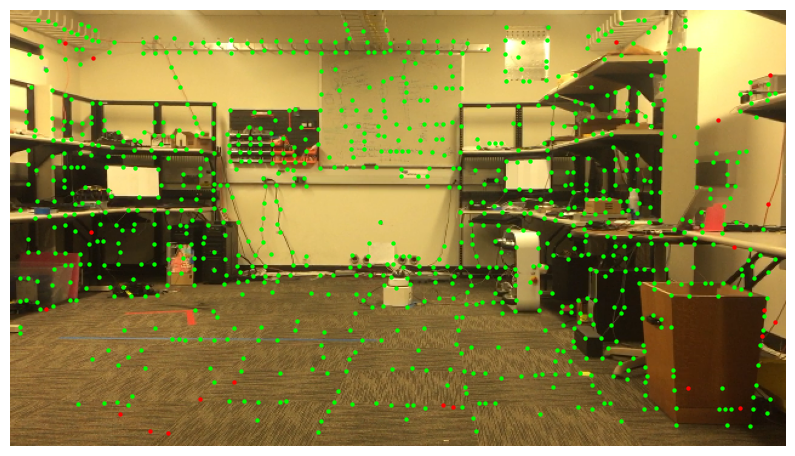

In [30]:
## send the image which you want to see
points_tracked(ReadImagesBinary,'iPhoSilWithWv3_1598592403_308-03780.png',dict_image_name )

2104


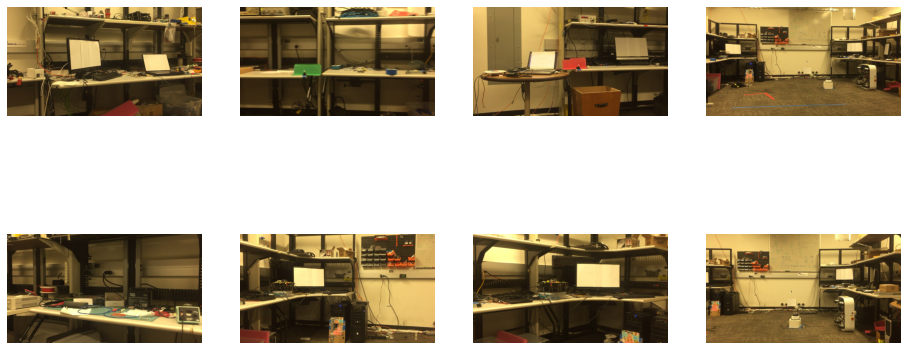

2104it [00:21, 99.69it/s] 


In [13]:
## send the path to query images
path_to_query = Path("/home/Hierarchical-Localization/datasets/UsefulImagesT4")
## this will create a list with all the image path in it
image_path_query = image_directory_parser(path_to_query, viewer=True, number = 4)
# dictionary_of_images creator gives image, its name and index as dictionary
image_dict_query = dictionary_of_images(image_path_query)

In [20]:
global_feature_path = output_path/"global_features_query.h5"
local_feature_path = output_path/"local_feature_query.h5"
global_feature_file = h5py.File(str(global_feature_path), 'w')
local_feature_file = h5py.File(str(local_feature_path), 'w')
global_feature_dict_query = {}
for i in tqdm(range(len(image_dict_query))):
    image = (image_dict_query[i]["image"]).astype(float)
#     print(image.shape)
    name = image_dict_query[i]["name"]
    db = hfnet.inference(image)
    grp = global_feature_file.create_group(str(name))
    grp.create_dataset('global_descriptor', data=db['global_descriptor'])
    if i == 0:
        global_matrix_query = np.array(db['global_descriptor'])
    else:
        global_matrix_query = np.vstack((global_matrix,db['global_descriptor'])) 
    global_feature_dict_query[i] = {"global_descriptor":db['global_descriptor'], "name":name}
    grp = local_feature_file.create_group(str(name))
    size = np.array(image.shape[:2][::-1])
#     print(size)
    grp.create_dataset('keypoints', data=db['keypoints'])
    grp.create_dataset('descriptors', data=np.transpose(db['local_descriptors']))
    grp.create_dataset('scores', data=db['scores'])
    grp.create_dataset('image_size', data= size)
    
global_feature_file.close()
local_feature_file.close()

100%|██████████| 2104/2104 [00:58<00:00, 36.03it/s]


In [21]:
def query_global_txt_file_creator(image_dict_query, image_dict_map, global_matrix, predictions_dict_query, path, file_name, number):
    with open(path/file_name, 'w') as f:
        for i in tqdm(range(len(predictions_dict_query))):
            current_descriptor = predictions_dict_query[i]["global_descriptor"]
            neighbours = compute_distance(current_descriptor, global_matrix)
            global_matches = ((np.argsort(neighbours))[:number])
            for j in range(len(global_matches)):
                if i == 0 and j ==0:
                    string = image_dict_query[i]["name"]+ " "+ image_dict_map[global_matches[j]]["name"]
                else:
                    string = "\n"+ image_dict_query[i]["name"]+ " "+ image_dict_map[global_matches[j]]["name"]
                f.write(string)

In [22]:
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)

In [14]:
global_file_txt = "global_query.txt"

In [23]:
query_global_txt_file_creator(image_dict_query, image_dict, global_matrix,global_feature_dict_query, output_path, global_file_txt, 10)

100%|██████████| 2104/2104 [00:00<00:00, 2588.76it/s]


In [15]:
from hloc import feature_matcher_map_query
matcher_conf_query = {'output': 'matcher_query', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
features_query = 'local_feature_query'
loc_pairs = output_path/global_file_txt

In [16]:
feature_matcher_map_query.main(matcher_conf_query, loc_pairs, features, output_path, features_query)

I0302 10:59:52.983848 139706515814208 feature_matcher_map_query.py:42] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matcher_query'}
I0302 10:59:52.985787 139706515814208 feature_matcher_map_query.py:50] Using query_features local_feature_query


Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 21040/21040 [18:20<00:00, 19.12it/s]
I0302 11:18:16.767862 139706515814208 feature_matcher_map_query.py:127] Finished exporting matches.


In [17]:
filename = "queries_with_intrinsics.txt"
with open(output_path/filename, 'w') as f:
    for i in range(len(image_path_query)):
        name = image_path_query[i].name
        if i ==0:
            string = str(name) + " "+ "SIMPLE_RADIAL"+ " " +str(640)+ " "+ str(480)+" " + str(658.503)+ " "+str(320)+ " " + str(180) + " "+str(0.0565491)
        else:
            string = "\n"+  str(name) + " "+ "SIMPLE_RADIAL"+ " " +str(640)+ " "+ str(480)+" " + str(658.503)+ " "+str(320)+ " " + str(180) + " "+str(0.0565491)
        f.write(string)    

In [18]:
feat_name = "local_feature_query.h5"
mat_name = "local_feature_matcher_query_global_query.h5"
res_name = 'results.txt'

In [19]:
from hloc import localize_sfm
localize_sfm.main(geo_registration_dir,
                 output_path/"queries_with_intrinsics.txt",
                 loc_pairs,
                 output_path/feat_name,
                 output_path/mat_name,
                 output_path/res_name,
                 covisibility_clustering=False)

I0302 11:18:16.967104 139706515814208 parsers.py:16] Importing 2104 queries in queries_with_intrinsics.txt
I0302 11:18:16.996188 139706515814208 localize_sfm.py:109] Reading 3D model...
I0302 11:18:18.752142 139706515814208 localize_sfm.py:123] Starting localization...
100%|██████████| 2104/2104 [04:12<00:00,  8.34it/s]
I0302 11:22:31.016340 139706515814208 localize_sfm.py:183] Localized 2104 / 2104 images.
I0302 11:22:31.017724 139706515814208 localize_sfm.py:184] Writing poses to /home/Hierarchical-Localization/outputs/sfm_T3_HFNET_pba/results.txt...
I0302 11:22:31.054863 139706515814208 localize_sfm.py:194] Writing logs to /home/Hierarchical-Localization/outputs/sfm_T3_HFNET_pba/results.txt_logs.pkl...
I0302 11:22:45.434744 139706515814208 localize_sfm.py:197] Done!


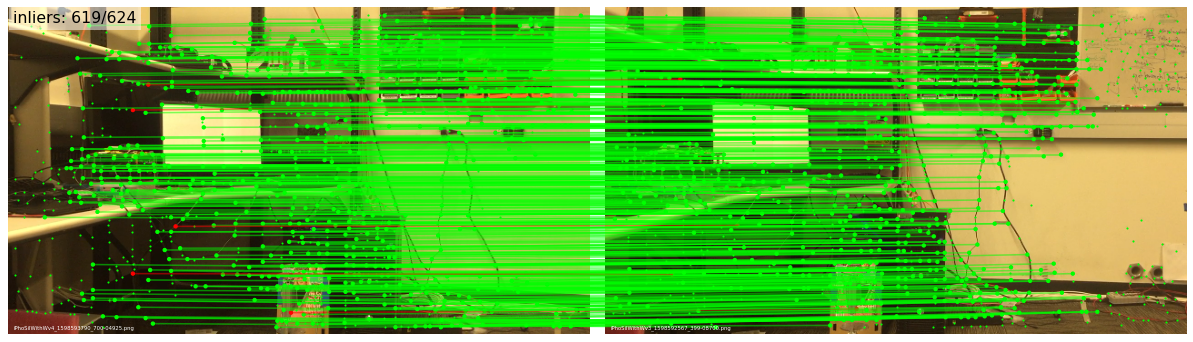

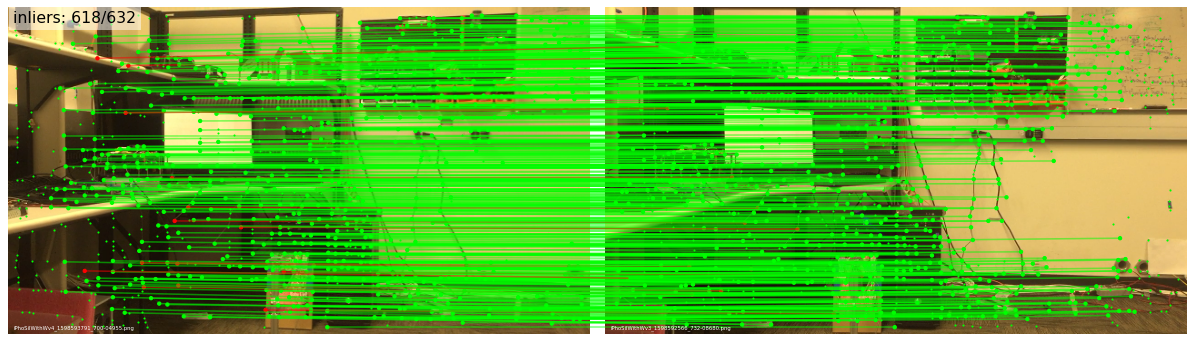

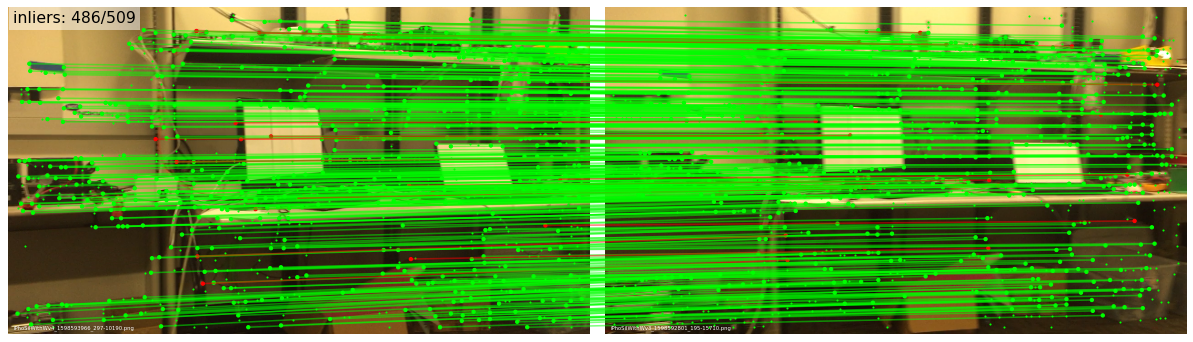

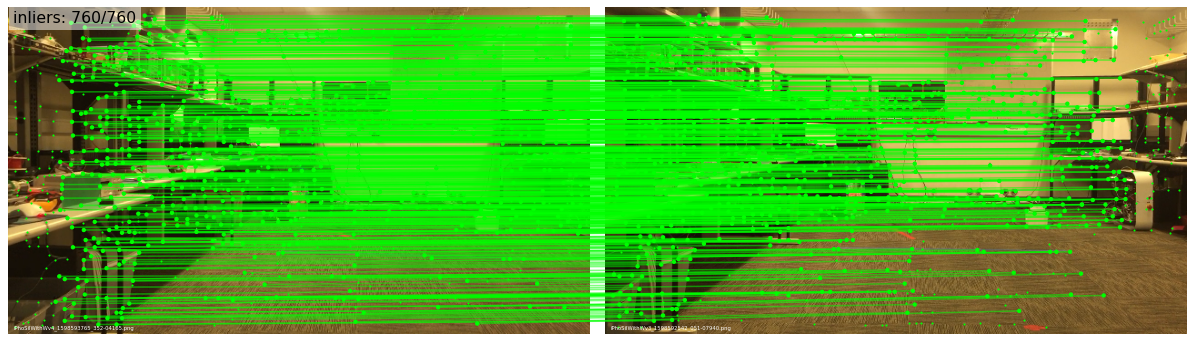

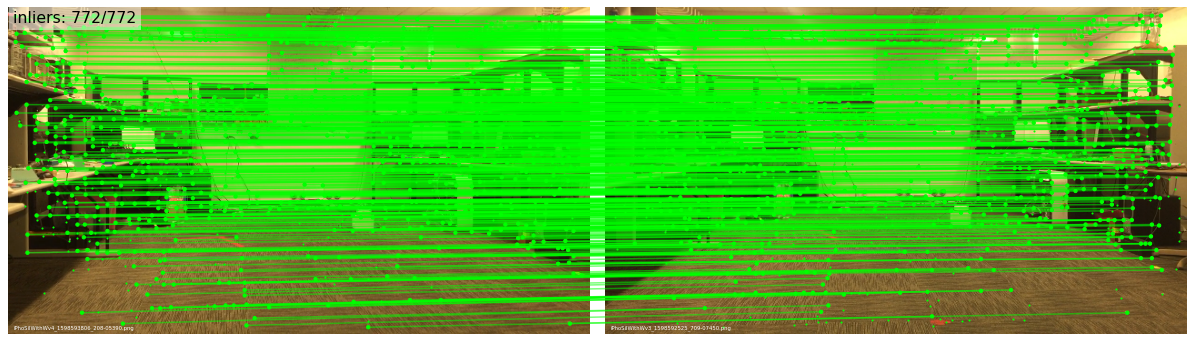

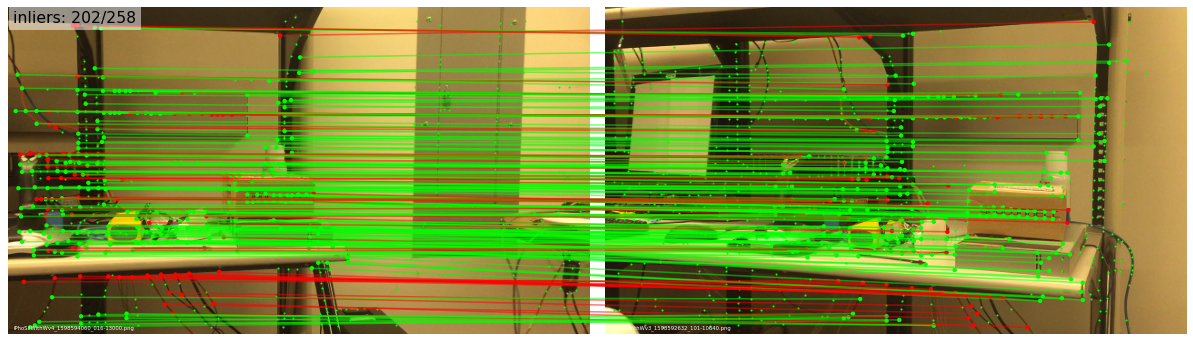

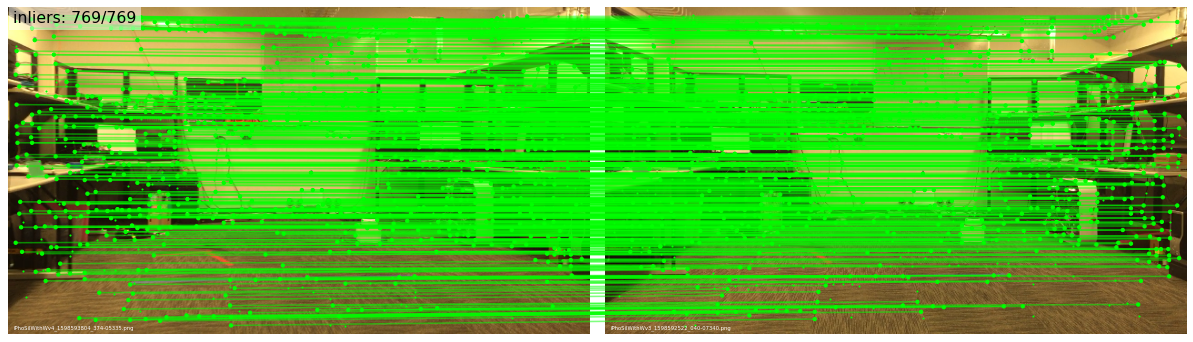

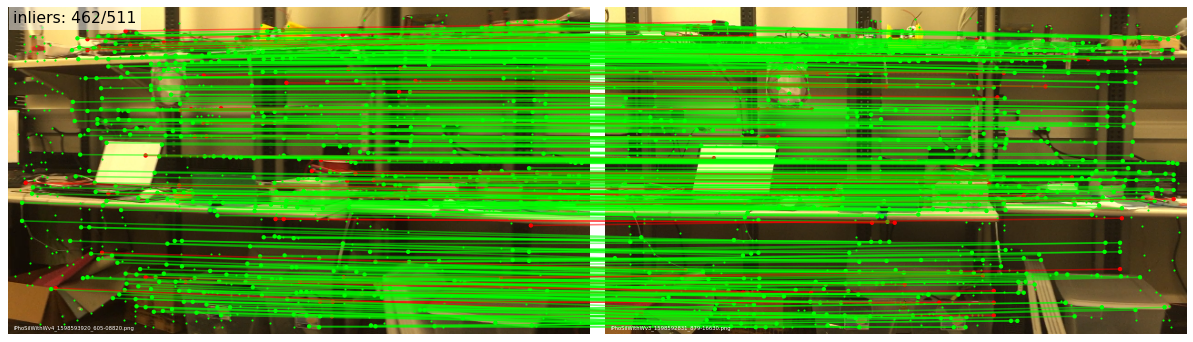

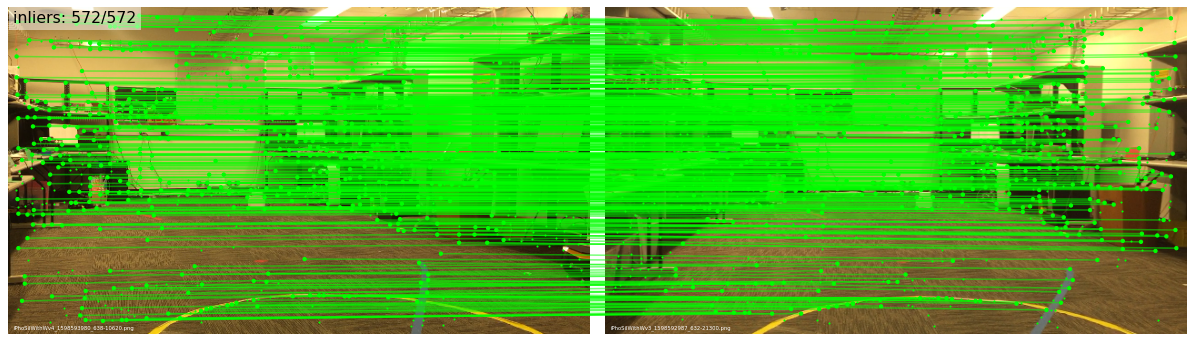

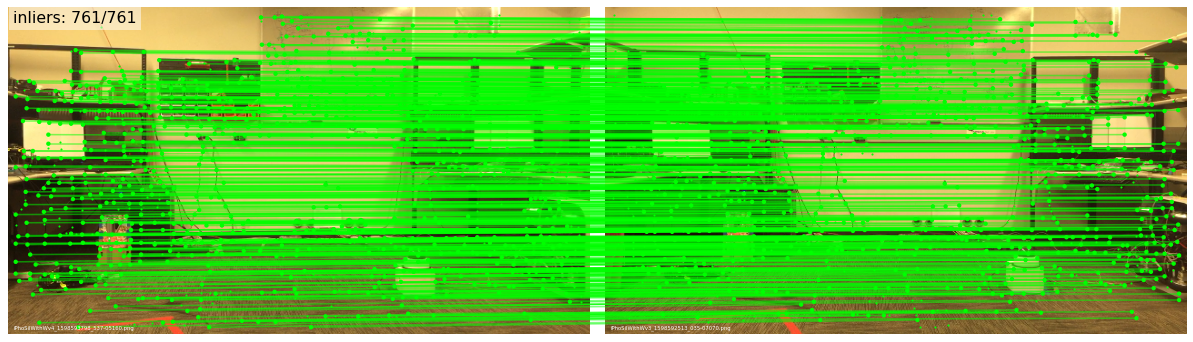

In [22]:
## to visualize tracked points
from hloc import  visualization
local_feature_path = output_path/'local_feature.h5'
local_feature_path_query = output_path/'local_feature_query.h5'
visualization.visualize_loc_new(
    output_path/res_name, path_to_images_for_map,path_to_query,local_feature_path, local_feature_path_query, geo_registration_dir , n=10, top_k_db=1, seed=2)

In [23]:
## ground truth for query images
names_trans_rot_query = jsonparser.parser("/home/Hierarchical-Localization/datasets/UsefulPosesT4HH")

In [24]:
len(names_trans_rot_query)

2104

In [25]:
def file_creator_error(original_dict_json, file_name_read, file_name_write, path):
    list_of_registered = list(original_dict_json.keys())
    with open(path/file_name_read, 'r') as f:
        Lines = f.readlines()
    error_list = []
    with open(path/file_name_write, 'w') as f:
        for line in Lines:
            line = line.split()
            name = line[0]
            qvec = np.asarray(line[1:5], dtype=np.float32)
#             qvec = np.array([line[2], line[3], line[4], line[1]],dtype=np.float32)
            tvec = np.asarray(line[5:8], dtype=np.float32)
            tvec_world = colmap_to_global(tvec, qvec)
            tvec_ori = original_dict_json[name]["tvec"]
            er =  error(tvec_world, tvec_ori)
            error_list.append(er)
            string = name + " "+ str(tvec_ori)+ " "+str(tvec_world)+ " " + str(er)+ "\n"
            f.write(string)
        error_list = np.asarray(error_list,  dtype=np.float32)
        string = "The median error is "+ str(np.median(error_list))+ '\n'
        f.write(string)
        string = "The mean error is "+ str(np.mean(error_list))+ '\n'
        f.write(string)
        string = "The max error is "+ str(np.max(error_list))
        f.write(string)

In [28]:
file_creator_error(names_trans_rot_query,res_name, "results_query_error.txt", output_path)